In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")

print("Path to dataset files:", path)

100%|██████████| 1.17G/1.17G [00:14<00:00, 88.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import random

RANDOM_STATE = 40
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [ ]:
classes = os.listdir(path + "/chest_xray/train")
print(classes)
classes_df = pd.DataFrame([{"index" : i, "name" : name} for i, name in enumerate(classes)], columns=["index", "name"])
print(classes_df.head())

image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]

def generate_images_df(set_type, class_names):
  data = pd.DataFrame(columns=["image_path", "class"])
  for class_name in classes_df["name"]:
    for image_file in os.listdir(f"{path}/chest_xray/{set_type}/{class_name}"):
        if any(image_file.endswith(ext) for ext in image_extensions):
            data.loc[len(data)] = [f"{path}/chest_xray/{set_type}/{class_name}/{image_file}", class_name]
  return data

train_data = generate_images_df('train', classes_df)
test_data = generate_images_df('test', classes_df)

print(train_data.head(9))
print(test_data.head(9))

['NORMAL', 'PNEUMONIA']
   index       name
0      0     NORMAL
1      1  PNEUMONIA
                                          image_path   class
0  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
1  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
2  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
3  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
4  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
5  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
6  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
7  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
8  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
                                          image_path   class
0  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
1  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
2  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
3  /root/.cache/kagglehub/datasets/tolgadincer/la...  NORMAL
4

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def apply_clahe_to_rgb(image_path):
    image = cv2.imread(image_path)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(image_lab)

    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)

    lab_eq = cv2.merge((l_eq, a, b))
    image_clahe = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    return image_clahe

def apply_clahe_to_df(df):
  # Crear nuevas imágenes CLAHE
  output_dir = 'clahe_images'
  os.makedirs(output_dir, exist_ok=True)

  for i, row in tqdm(df.iterrows(), total=len(df)):
      new_img = apply_clahe_to_rgb(row["image_path"])
      new_path = os.path.join(output_dir, os.path.basename(row["image_path"]))
      cv2.imwrite(new_path, new_img)
      df.at[i, "image_path"] = new_path

  return df

test_data = apply_clahe_to_df(test_data)
train_data = apply_clahe_to_df(train_data)


100%|██████████| 4185/4185 [03:18<00:00, 21.09it/s]


In [ ]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(train_data, test_size=0.2, shuffle=True,random_state=RANDOM_STATE)

Train classes:
class
PNEUMONIA    3111
NORMAL       1074
Name: count, dtype: int64


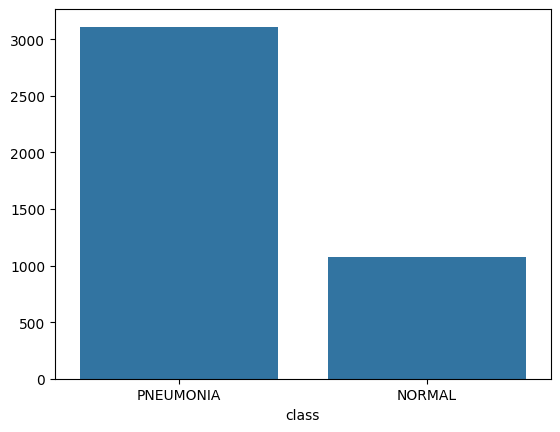

Validation classes:
class
PNEUMONIA    772
NORMAL       275
Name: count, dtype: int64


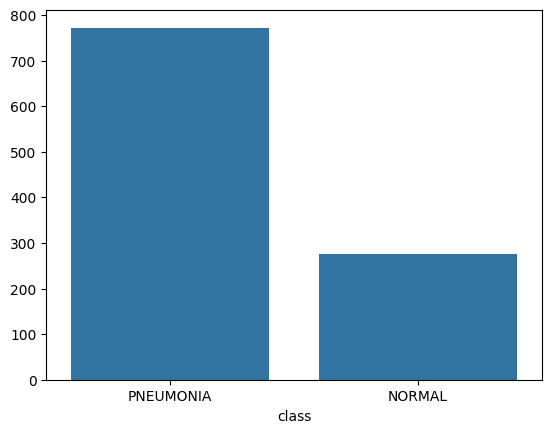

Test classes:
class
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


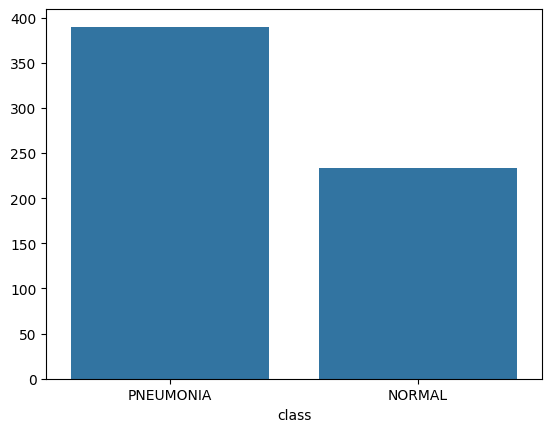

In [ ]:
train_classes = train_data["class"].value_counts()
validation_classes = validation_data["class"].value_counts()
test_classes = test_data["class"].value_counts()

print("Train classes:")
print(train_classes)
sns.barplot(x=train_classes.index, y=train_classes.values)
plt.show()

print("Validation classes:")
print(validation_classes)
sns.barplot(x=validation_classes.index, y=validation_classes.values)
plt.show()

print("Test classes:")
print(test_classes)
sns.barplot(x=test_classes.index, y=test_classes.values)
plt.show()

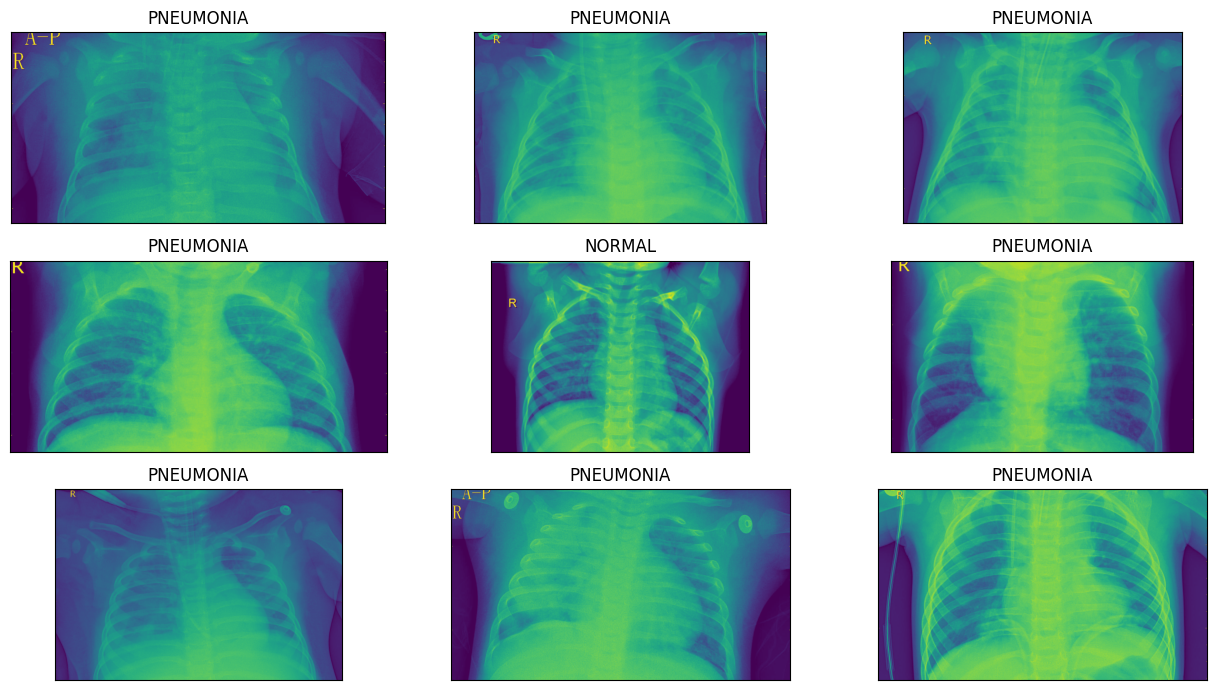

In [ ]:
train_data = train_data.sample(frac=1)

f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(train_data.iloc[i]["image_path"]))
    ax.set_title(train_data.iloc[i]["class"])

plt.tight_layout()
plt.show()

In [ ]:
from keras.applications import VGG16, ResNet50
from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

def create_vgg_model(learning_rate=0.001, compile=True):
    # Load pre-trained VGG16
    base_model = VGG16(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet'
    )

    for layer in base_model.layers:
      layer.trainable = False

    # Create the model
    model = models.Sequential([
        #base_model,
        #layers.Flatten(),
        #layers.Dense(128, activation='relu'),
        #layers.Dropout(0.5),
        #layers.Dense(1, activation='sigmoid')

        base_model,
        layers.Flatten(),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')  # Para clasificación binaria
    ])

    # Compile the model
    if(compile):
      model.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy']
      )

    return model, base_model

def create_resnet_model(learning_rate=0.001, compile=True):
    # Load pre-trained ResNet50
    base_model = ResNet50(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.Flatten(),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')  # Para clasificación binaria
    ])

    # Compile the model
    if(compile):
      model.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss='binary_crossentropy',
          metrics=['accuracy']
      )

    return model, base_model

def get_callbacks(model_name):
    """Get training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=2,
            verbose=1
        )
    ]
    return callbacks

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Detailed model comparison
def evaluate_model(model, test_images, training_images):
    """Evaluate model and return detailed metrics"""
    # Predictions
    y_pred = model.predict(test_images)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    labels = (training_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    y_pred_classes = [labels[k] for k in y_pred_classes]
    y_true_classes =  test_data["class"].values

    # Metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)

    # Classification report
    report = classification_report(y_true_classes, y_pred_classes,
                                   target_names=labels, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'pred_classes': y_pred_classes,
        'true_classes': y_true_classes
    }

print("Model building functions defined")

Model building functions defined


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data["class"]),
    y=train_data["class"]
)

# Convierte a dict para usar en model.fit()
class_weights_dict = dict(enumerate(class_weights))


# VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# Create and train VGG model
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess, zoom_range = 0.2, width_shift_range = 0.1, height_shift_range = 0.1)
#train_datagen = ImageDataGenerator(
#    preprocessing_function=vgg_preprocess,
#    rotation_range=15,                # Rotaciones leves
#    zoom_range=0.15,                  # Zoom más amplio
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    shear_range=0.1,                  # Deformación en diagonal
#    horizontal_flip=True,            # Inversión horizontal
#    fill_mode='nearest'              # Cómo rellenar los bordes
#)
training_images = train_datagen.flow_from_dataframe(train_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', shuffle=True, seed=RANDOM_STATE,
                                            target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)
validation_images = test_datagen.flow_from_dataframe(validation_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
test_images = test_datagen.flow_from_dataframe(test_data, x_col="image_path", y_col="class", color_mode='rgb', class_mode='binary',
                                        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf

print("Creating VGG16 model...")
tf.keras.backend.clear_session()
vgg_model, base_vgg = create_vgg_model(LEARNING_RATE)
vgg_model.summary()

# Train VGG model
print("\nTraining VGG16 model...")
vgg_history = vgg_model.fit(
    training_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_images,
    callbacks=get_callbacks('vgg'),
    class_weight=class_weights_dict
)

# Evaluate VGG model
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_images)
print(f"\nVGG16 Test Accuracy: {vgg_test_acc:.4f}")
print(f"VGG16 Test Loss: {vgg_test_loss:.4f}")

Creating VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322,881 (62.27 MB)

 Trainable params: 1,608,001 (6.13 MB)

 Non-trainable params: 14,714,880 (56.13 MB)


Training VGG16 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7504 - loss: 0.5016 - val_accuracy: 0.7679 - val_loss: 0.5496 - learning_rate: 1.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 789ms/step - accuracy: 0.8738 - loss: 0.2997 - val_accuracy: 0.8395 - val_loss: 0.3815 - learning_rate: 1.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 776ms/step - accuracy: 0.9092 - loss: 0.2415 - val_accuracy: 0.8739 - val_loss: 0.3458 - learning_rate: 1.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 723ms/step - accuracy: 0.9310 - loss: 0.2189 - val_accuracy: 0.8883 - val_loss: 0.3088 - learning_rate: 1.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 724ms/step - accuracy: 0.9300 - loss: 0.1966 - val_accuracy: 0.8787 - val_loss: 0.3475 - learning_rate: 1.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 94s 715ms/step - accuracy: 0.9422 - loss: 0.1832 - val_accuracy: 0.8902 - val_loss: 0.3069 - learning_rate: 1.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 72

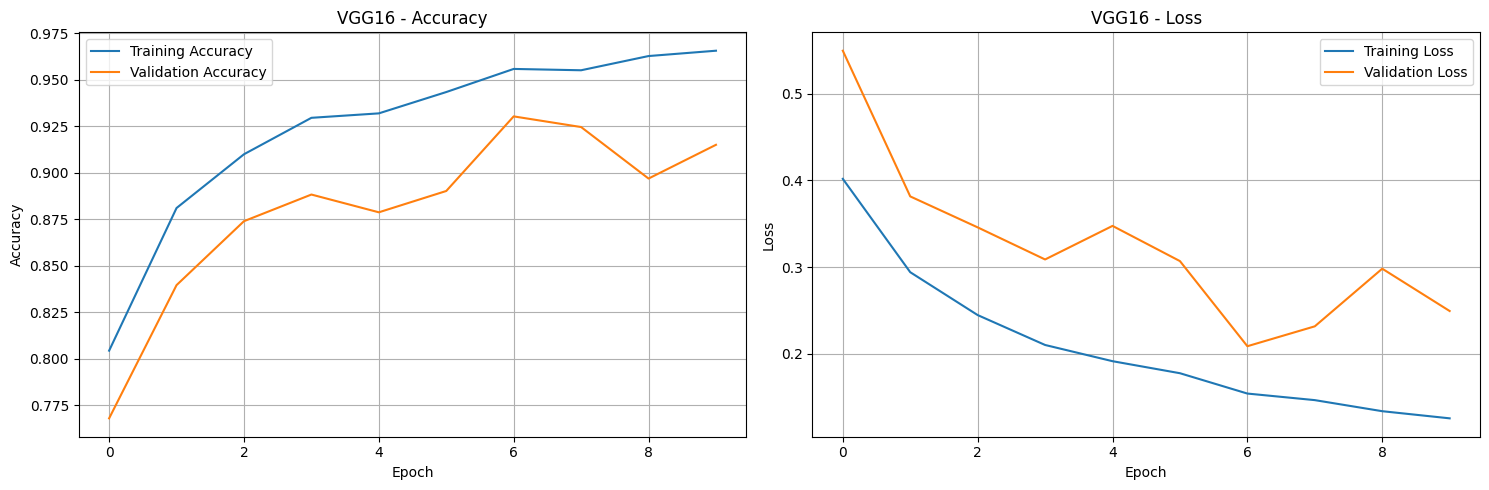

In [ ]:
# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# VGG Training History
axes[0].plot(vgg_history.history['accuracy'], label='Training Accuracy')
axes[0].plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('VGG16 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(vgg_history.history['loss'], label='Training Loss')
axes[1].plot(vgg_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('VGG16 - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
vgg_results = evaluate_model(vgg_model, test_images, training_images)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step


In [ ]:
vgg_results['accuracy']

0.9631410256410257

<Axes: >

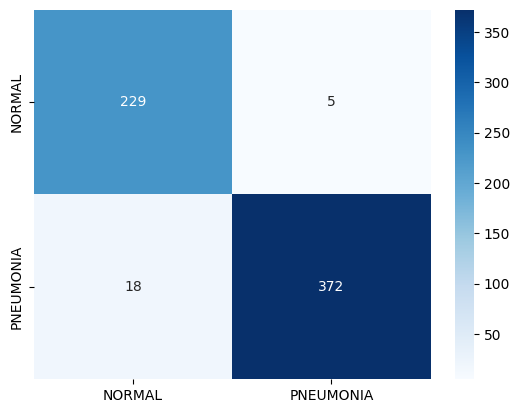

In [ ]:
sns.heatmap(vgg_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

In [ ]:
pd.DataFrame(vgg_results['report'])

,0,1,accuracy,macro avg,weighted avg
precision,0.927126,0.986737,0.963141,0.956931,0.964383
recall,0.978632,0.953846,0.963141,0.966239,0.963141
f1-score,0.952183,0.970013,0.963141,0.961098,0.963327
support,234.000000,390.000000,0.963141,624.000000,624.000000


In [ ]:
vgg_model.save_weights('vgg_best.weights.h5')

In [ ]:
fine_tune_vgg, base = create_vgg_model(compile=False)
fine_tune_vgg.load_weights('vgg_best.weights.h5')

for layer in base.layers[-4:]:
  layer.trainable = True

fine_tune_vgg.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 20
history_finetune = fine_tune_vgg.fit(
    training_images,
    epochs=fine_tune_epochs,
    validation_data=validation_images,
    callbacks=get_callbacks('vgg_finetune'),
    class_weight=class_weights_dict
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 769ms/step - accuracy: 0.9540 - loss: 0.1484 - val_accuracy: 0.9054 - val_loss: 0.2958 - learning_rate: 1.0000e-05
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 742ms/step - accuracy: 0.9532 - loss: 0.1517 - val_accuracy: 0.9035 - val_loss: 0.3077 - learning_rate: 1.0000e-05
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 738ms/step - accuracy: 0.9674 - loss: 0.1303 - val_accuracy: 0.9064 - val_loss: 0.2790 - learning_rate: 1.0000e-05
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 732ms/step - accuracy: 0.9707 - loss: 0.1183 - val_accuracy: 0.9207 - val_loss: 0.2413 - learning_rate: 1.0000e-05
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 802ms/step - accuracy: 0.9713 - loss: 0.1108 - val_accuracy: 0.9083 - val_loss: 0.2648 - learning_rate: 1.0000e-05
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 741ms/step - accuracy: 0.9808 - loss: 0.1059 - val_accuracy: 0.9245 - val_loss: 0.2247 - learning_rate: 1.0000e-05
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 

In [ ]:
vgg_tune_results = evaluate_model(fine_tune_vgg, test_images, training_images)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step


In [ ]:
vgg_tune_results['accuracy']

0.9663461538461539

<Axes: >

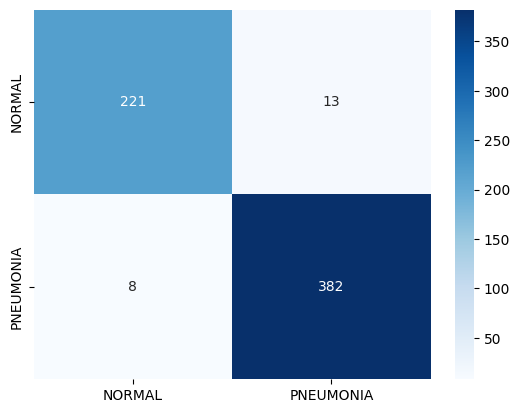

In [ ]:
sns.heatmap(vgg_tune_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

In [ ]:
pd.DataFrame(vgg_tune_results['report'])

,0,1,accuracy,macro avg,weighted avg
precision,0.965066,0.967089,0.966346,0.966077,0.966330
recall,0.944444,0.979487,0.966346,0.961966,0.966346
f1-score,0.954644,0.973248,0.966346,0.963946,0.966272
support,234.000000,390.000000,0.966346,624.000000,624.000000


In [ ]:
# Guardar modelos completos
vgg_model.save("vgg_model_base.keras")
vgg_model.save_weights("vgg_model_base.weights.h5")

fine_tune_vgg.save("vgg_model_finetuned.keras")
fine_tune_vgg.save_weights("vgg_model_finetuned.weights.h5")

# Descargar archivos a tu PC
from google.colab import files

files.download("vgg_model_base.keras")
files.download("vgg_model_base.weights.h5")

files.download("vgg_model_finetuned.keras")
files.download("vgg_model_finetuned.weights.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
vgg_model.save("vgg_model_base.h5")
fine_tune_vgg.save("vgg_model_finetuned.h5")


# ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Create and train VGG model
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess, zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1)
training_images = train_datagen.flow_from_dataframe(train_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', shuffle=True, seed=RANDOM_STATE,
                                            target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
validation_images = test_datagen.flow_from_dataframe(validation_data, x_col="image_path", y_col="class", color_mode='rgb',
                                            class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
test_images = test_datagen.flow_from_dataframe(test_data, x_col="image_path", y_col="class", color_mode='rgb', class_mode='binary',
                                        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
# Create and train ResNet model
print("Creating ResNet50 model...")
resnet_model, _ = create_resnet_model(learning_rate=LEARNING_RATE)
resnet_model.summary()

# Train ResNet model
print("\nTraining ResNet50 model...")
resnet_history = resnet_model.fit(
    training_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_images,
    callbacks=get_callbacks('resnet'),
    verbose=1
)

# Evaluate ResNet model
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_images)
print(f"\nResNet50 Test Accuracy: {resnet_test_acc:.4f}")
print(f"ResNet50 Test Loss: {resnet_test_loss:.4f}")

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Creating ResNet50 model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,012,801 (114.49 MB)

 Trainable params: 6,424,897 (24.51 MB)

 Non-trainable params: 23,587,904 (89.98 MB)


Training ResNet50 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 115s 782ms/step - accuracy: 0.6331 - loss: 0.6735 - val_accuracy: 0.7832 - val_loss: 0.6514 - learning_rate: 1.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 687ms/step - accuracy: 0.8690 - loss: 0.3997 - val_accuracy: 0.9007 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 673ms/step - accuracy: 0.9116 - loss: 0.3217 - val_accuracy: 0.9303 - val_loss: 0.3351 - learning_rate: 1.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 691ms/step - accuracy: 0.9443 - loss: 0.2613 - val_accuracy: 0.9360 - val_loss: 0.2797 - learning_rate: 1.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 675ms/step - accuracy: 0.9610 - loss: 0.2193 - val_accuracy: 0.9465 - val_loss: 0.2449 - learning_rate: 1.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 673ms/step - accuracy: 0.9640 - loss: 0.1992 - val_accuracy: 0.9389 - val_loss: 0.2503 - learning_rate: 1.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 6

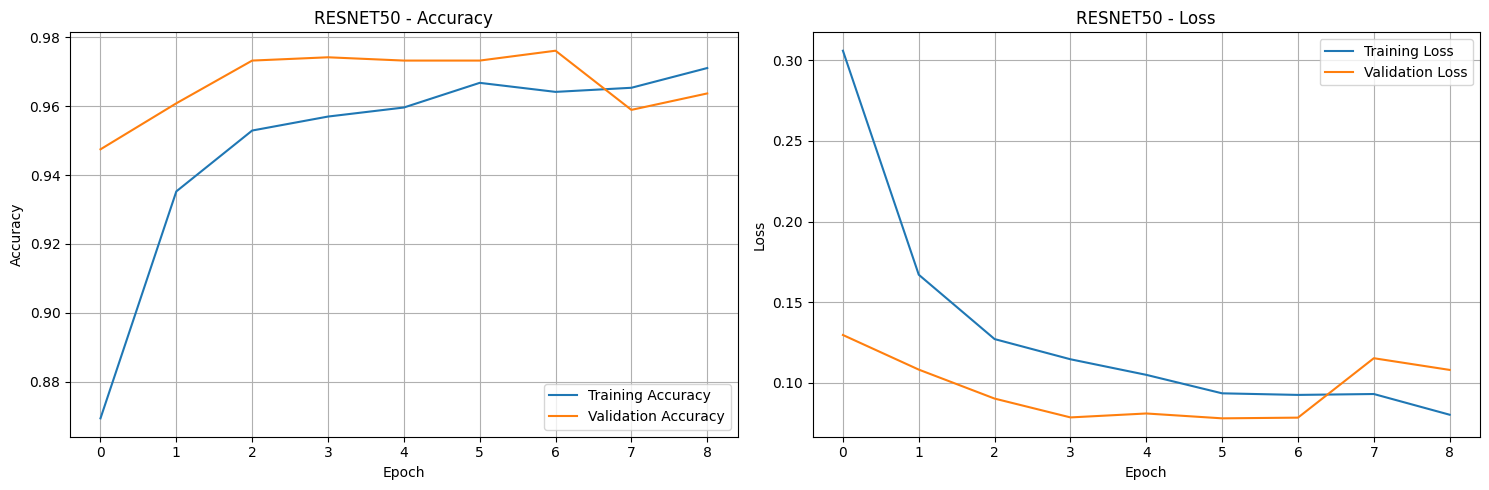

In [ ]:
# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# VGG Training History
axes[0].plot(resnet_history.history['accuracy'], label='Training Accuracy')
axes[0].plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('RESNET50 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(resnet_history.history['loss'], label='Training Loss')
axes[1].plot(resnet_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('RESNET50 - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
resnet_results = evaluate_model(resnet_model, test_images, training_images)

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step


In [ ]:
resnet_results['accuracy']

0.9503205128205128

<Axes: >

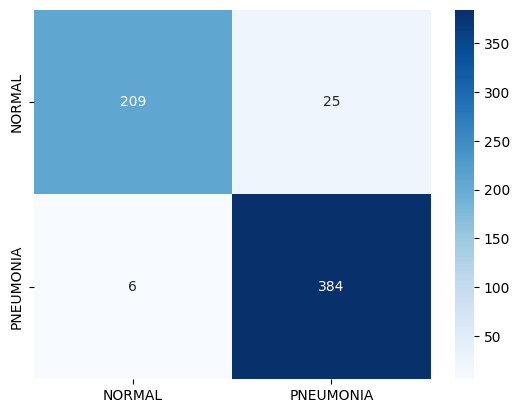

In [ ]:
sns.heatmap(resnet_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

In [ ]:
pd.DataFrame(resnet_results['report'])

,0,1,accuracy,macro avg,weighted avg
precision,0.972093,0.938875,0.950321,0.955484,0.951332
recall,0.893162,0.984615,0.950321,0.938889,0.950321
f1-score,0.930958,0.961202,0.950321,0.946080,0.949860
support,234.000000,390.000000,0.950321,624.000000,624.000000


In [ ]:
resnet_model.save_weights('resnet_best.weights.h5')

In [ ]:
fine_tune_resnet, base = create_resnet_model(compile=False)
fine_tune_resnet.load_weights('resnet_best.weights.h5')

for layer in base.layers[-10:]:
  layer.trainable = True

fine_tune_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
history_finetune = fine_tune_resnet.fit(
    training_images,
    epochs=fine_tune_epochs,
    validation_data=validation_images,
    callbacks=get_callbacks('vgg_finetune'),
    class_weight=class_weights_dict
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 762ms/step - accuracy: 0.9781 - loss: 0.1225 - val_accuracy: 0.9570 - val_loss: 0.1680 - learning_rate: 1.0000e-05
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 671ms/step - accuracy: 0.9747 - loss: 0.1166 - val_accuracy: 0.9561 - val_loss: 0.1860 - learning_rate: 1.0000e-05
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9811 - loss: 0.1076
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 671ms/step - accuracy: 0.9811 - loss: 0.1076 - val_accuracy: 0.9503 - val_loss: 0.2011 - learning_rate: 1.0000e-05
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 674ms/step - accuracy: 0.9792 - loss: 0.1099 - val_accuracy: 0.9503 - val_loss: 0.2016 - learning_rate: 1.0000e-06
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
fine_resnet_results = evaluate_model(fine_tune_resnet, test_images, training_images)

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step


In [ ]:
fine_resnet_results['accuracy']

0.9535256410256411

<Axes: >

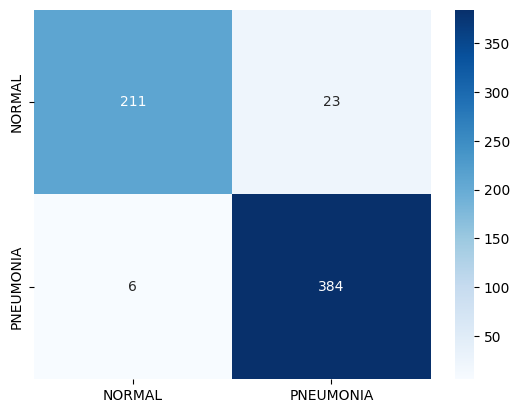

In [ ]:
sns.heatmap(fine_resnet_results['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])

In [ ]:
pd.DataFrame(fine_resnet_results['report'])

,0,1,accuracy,macro avg,weighted avg
precision,0.972350,0.943489,0.953526,0.957920,0.954312
recall,0.901709,0.984615,0.953526,0.943162,0.953526
f1-score,0.935698,0.963614,0.953526,0.949656,0.953145
support,234.000000,390.000000,0.953526,624.000000,624.000000
